In [27]:
import random
from random import randint, shuffle
import matplotlib.pyplot as plt
import numpy as np
import math

class Clause:                    
    def __init__(self, elems, weight):
        self._elems = elems        #the elements in a clause
        self._weight = weight      #the weight for each clause
    def evaluate (self,variables):
        res = 1
        
        n = len(self._elems)
        
        for i in range(0,n):
            x = abs(self._elems[i]) - 1   # <0 => not; >0 => normal; we start from 1 / -1 (for clause 0)
            if self._elems[i] < 0 :
                res *= (1 - variables[x])
            else:
                res *= variables[x]
        return res * self._weight
    def getWeight(self):
        return self._weight


class Organism:
    def __init__(self, genome, env, prob):     #env = environment = list of clauses
        self._genome = genome
        self._env = env
        self._fitness = self._computeFitness()
        self._prob = prob
    
    def _computeFitness(self):
        solvedClauses = 0
        clauseNum = len(self._env)
        for clause in self._env :
            solvedClauses += clause.evaluate(self._genome)
        return solvedClauses + 1         #fitness >= 1
    
    def mutate(self):                        #triggers a mutation cycle where each gene can change with probability prob
        varNum = len(self._genome)
        for i in range(0, varNum) :
            doMutation = np.random.binomial(1, self._prob, 1)
            if doMutation == 1:
                self._genome[i] = 1 - self._genome[i]
        self._fitness = self._computeFitness()
        
    def offsprings(self, totalFitness, orgNum, label, dct):                    #returns a list of offsprings based on the current fitness
        offsprings = []
        myFitness = self._fitness               
        s = int(np.random.poisson(myFitness - 1, 1) + 1)   #draw a sample from Poisson distribution; we ensure that each organism has at least one offspring
        dct[label] = Organism(self._genome.copy(), self._env, self._prob);
        for i in range (0, s):                                  # we must have at most n children, so we integrate this directly in the sampling
            offsprings.append(label)
        return offsprings
    
    def getFitness(self):
        return self._fitness
    
    def getGenome(self):
        return self._genome.copy()
    
    def computeMutants(self) :   #returns a list of all the possible mutants of an organism at Hamming distance 1
        res = []
        l = len(self._genome)
        for i in range (0, l) :
            newGenome = self._genome.copy()
            newGenome[i] = 1 - newGenome[i]
            res.append(Organism(newGenome, self._env, self._prob))
        return res


class LocalStatistics:     #computes local optimality statistics, regarding the fittest closest mutant
    def __init__(self, population, maxPossibleFitness) :
        self._population = population
        self._maxFitList = []      #fitness of the fittest mutant after each round
        self._avgMutList = []      #average fitness of the possible mutants per round
        self._avgFitterList = []   #average fitness of the possible mutants that have higher fitness per round
        self._maxPossibleFitness = maxPossibleFitness   #used to normalize fitness before plotting
        self._normList = []     #used to display the normalization equivalent
        self._neighbourData = {}
        self._max5SelList = []
        self._min5SelList = []
        self._maxSelList = []
        self._minSelList = []
        self._avgSelList = []
        
    def updateStats(self) :
        rnd = self._population.getRound()
        roundNeighbourData = {}
        (maxDFit, avgMut, avgFitter) = self._computeStats(roundNeighbourData)
        self._neighbourData[rnd] = roundNeighbourData
        self._maxFitList.append((rnd, maxDFit))
        self._avgMutList.append((rnd, avgMut))
        self._avgFitterList.append((rnd, avgFitter))
        self._normList.append((rnd, 1 / self._maxPossibleFitness))
        (maxSel, minSel, max5Sel, min5Sel, avgSel) = self._computeSelection(roundNeighbourData)  #compute the selection coefficients statistics
        self._maxSelList.append((rnd, maxSel)) 
        self._minSelList.append((rnd, minSel))
        self._min5SelList.append((rnd, min5Sel))
        self._max5SelList.append((rnd, max5Sel))
        self._avgSelList.append((rnd, avgSel))
     
        
    def plotStats(self):     #plot all the stats so far; each stat can also be plotted separately
        plt.title("Local fitness statistics")
        plt.xlabel("Rounds")
        plt.ylabel(r'$\Delta$' + ' raw fitness')
        self.plotMaxFit()
        self.plotAvgMut()
        self.plotAvgFitter()
        self.plotNorm()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
        plt.title("Selection coefficient statistics")
        plt.xlabel("Rounds")
        plt.ylabel("Selection coefficient")
        self.plotAvgSel()
        self.plotMinSel()
        self.plotMaxSel()
        self.plotMin5Sel()
        self.plotMax5Sel()
        self._fillPlot(self._maxSelList, self._max5SelList)  #fill between max and max 5 percent
        self._fillPlot(self._minSelList, self._min5SelList)  #fill between min and min 5 percent
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
        
    def _fillPlot(self, extreme, middle):
        xs = [x[0] for x in extreme]  #fill between 2 lines
        ys1 = [x[1] for x in extreme]
        ys2 = [x[1] for x in middle]
        plt.fill_between(xs, ys1, ys2, color = "royalblue")
        
    def plotMax5Sel(self):
        self._plotSelStat(self._max5SelList, "Maximum 5% average", "green")
        
    def plotMin5Sel(self):
        self._plotSelStat(self._min5SelList, "Minimum 5% average", "green")
    
    def plotAvgSel(self):
        self._plotSelStat(self._avgSelList, "Average", "red")
    
    def plotMaxSel(self):
        self._plotSelStat(self._maxSelList, "Maximum", "blue")
        
    def plotMinSel(self):
        self._plotSelStat(self._minSelList, "Minimum", "blue")
    
    def _plotSelStat(self, statList, des, clr):
        xs = [x[0] for x in statList]
        ys = [x[1] for x in statList]
        plt.plot(xs,ys, label = des, color = clr)
        
        
    def plotNorm(self):
        self._plotStat(self._normList, "Normalization value", '--')
        
    def plotMaxFit(self):
        self._plotStat(self._maxFitList, "Fittest possible mutant")
        
    def plotAvgMut(self):
        self._plotStat(self._avgMutList, "Average of possible mutants")
        
    def plotAvgFitter(self):
        self._plotStat(self._avgFitterList, "Average of possible mutants that are fitter")
        
    def _plotStat(self, statList, des, lineType = '-'):
        xs = [x[0] for x in statList]
        ys = [x[1] for x in statList]
        plt.plot(xs, ys, lineType, label = des)
        
    def _computeStats(self, roundNeighbourData):
        maxDFit = 0
        sAvgMut = 0
        nAvgMut = 0
        sAvgFitter = 0
        nAvgFitter = 0
        for org in self._population.getOrganisms():
            mutantsDeltaFitness = []
            mutants = org.computeMutants()
            for x in mutants:
                dFit = x.getFitness() - org.getFitness()
                mutantsDeltaFitness.append(dFit)
                if dFit > maxDFit:
                    maxDFit = dFit
                sAvgMut += dFit
                nAvgMut += 1
                if dFit > 0:    #fitter than its parent
                    sAvgFitter += dFit
                    nAvgFitter += 1
            roundNeighbourData[org] = (org.getFitness(), mutantsDeltaFitness)  #compute the neighbour data for for the current round
        if nAvgFitter == 0:
            nAvgFitter = 1
        return (maxDFit, sAvgMut / nAvgMut, sAvgFitter / nAvgFitter)
                                
    def _computeSelection(self, roundNeighbourData):
        selection = []
        for org in self._population.getOrganisms():
            (fit, mutDeltaFit) = roundNeighbourData[org]
            maxMutDeltaFit = max(mutDeltaFit)
            selection.append(maxMutDeltaFit / fit)     #compute the selection coefficient
        selection.sort()
        maxSel = selection[-1]
        minSel = selection[0]
        size = len(selection)
        size5per = int (math.ceil(size * 0.05))
        max5Sel = np.mean(selection[size - size5per : size])
        min5Sel = np.mean(selection[:size5per])
        avgSel = np.mean(selection)
        return (maxSel, minSel, max5Sel, min5Sel, avgSel)
        
                                
    def getNeighbourData(self):
        return self._neighbourData;    #this contains the local data (neighbour data) for a round, and organism, its fitness and its possible mutants fitness
    
    #For the visualisation of this:
    #Show data for a specific round / show data using joyplots (might not be easy to understand)
    #How to visualize the data for the population: 3D graph / joyplots / show separate distribution for organisms and then for mutants for each organism


class Statistics:                       #contains all the statistics and methods to update and plot them for a population
    def __init__(self, population, maxPossibleFitness, orgNum) :
        self._population = population
        self._avgFitList = []
        self._maxFitList = []
        self._minFitList = []
        self._max5PerFitList = []
        self._min5PerFitList = []
        self._maxPossibleFitness = maxPossibleFitness   #used to normalize fitness before plotting
        self._orgNum = orgNum
        
    def updateStats(self):
        rnd = self._population.getRound()
        self._avgFitList.append((rnd, self._computeAvgFit() / self._maxPossibleFitness))
        self._maxFitList.append((rnd, self._computeMaxFit() / self._maxPossibleFitness))
        self._minFitList.append((rnd, self._computeMinFit() / self._maxPossibleFitness))
        self._max5PerFitList.append((rnd, self._computeMax5PerFit() / self._maxPossibleFitness))
        self._min5PerFitList.append((rnd, self._computeMin5PerFit() / self._maxPossibleFitness))
        
        
    def plotStats(self):     #plot all the stats so far; each stat can also be plotted separately
        plt.title("General fitness statistics")
        plt.xlabel("Rounds")
        plt.ylabel("Normalized fitness")
        self.plotAvgFit()
        self.plotMinFit()
        self.plotMaxFit()
        self.plotMin5PerFit()
        self.plotMax5PerFit()
        self._fillPlot(self._maxFitList, self._max5PerFitList)  #fill between max and max 5 percent
        self._fillPlot(self._minFitList, self._min5PerFitList)  #fill between min and min 5 percent
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
        
    def _fillPlot(self, extreme, middle):
        xs = [x[0] for x in extreme]  #fill between 2 lines
        ys1 = [x[1] for x in extreme]
        ys2 = [x[1] for x in middle]
        plt.fill_between(xs, ys1, ys2, color = "royalblue")
        
    def plotMax5PerFit(self):
        self._plotStat(self._max5PerFitList, "Maximum 5% average", "green")
        
    def plotMin5PerFit(self):
        self._plotStat(self._min5PerFitList, "Minimum 5% average", "green")
    
    def plotAvgFit(self):
        self._plotStat(self._avgFitList, "Average", "red")
    
    def plotMaxFit(self):
        self._plotStat(self._maxFitList, "Maximum", "blue")
        
    def plotMinFit(self):
        self._plotStat(self._minFitList, "Minimum", "blue")
    
    def _plotStat(self, statList, des, clr):
        xs = [x[0] for x in statList]
        ys = [x[1] for x in statList]
        plt.plot(xs,ys, label = des, color = clr)
        
    def _computeAvgFit(self):
        s = 0
        orgs = self._population.getOrganisms()
        for i in range(0, self._orgNum):
            s += orgs[i].getFitness()
        return s / self._orgNum
        
    def _computeMaxFit(self):
        maxFit = 0
        orgs = self._population.getOrganisms()
        for i in range(0, self._orgNum):
            fit = orgs[i].getFitness()
            if fit > maxFit:
                maxFit = fit
        return maxFit
    
    def _computeMinFit(self):
        minFit = 1000000000
        orgs = self._population.getOrganisms()
        for i in range(0, self._orgNum):
            fit = orgs[i].getFitness()
            if fit < minFit:
                minFit = fit
        return minFit
    
    def _computeMin5PerFit(self):
        orgs = self._population.getOrganisms()
        fit = []
        for i in range(0, self._orgNum):
            fit.append(orgs[i].getFitness())
        fit.sort()
        l = int(math.ceil(len(fit) * 0.05))      #get only the first 5%
        fit = fit[:l]
        s = 0
        for x in fit:                            #compute the average of it
            s += x
        return s / l
    
    def _computeMax5PerFit(self):
        orgs = self._population.getOrganisms()
        fit = []
        for i in range(0, self._orgNum):
            fit.append(orgs[i].getFitness())
        fit.sort(reverse = True)
        l = int(math.ceil(len(fit) * 0.05))      #get only the first 5% (biggest 5%)
        fit = fit[:l]
        s = 0
        for x in fit:                            #compute the average of it
            s += x
        return s / l
    
    def plotGenome(self):
        orgs = self._population.getOrganisms()
        for org in orgs:
            print(str(org.getFitness()) + "   " + str(org.getGenome()))


class Population:                        #contains the current population and statistics; is updated on nextGeneration call
    def __init__(self, orgNum, env, prob, initial):
        self._orgNum = orgNum
        self._env = env
        self._prob = prob
        self._organisms = []
        self._round = 0
        self._maxPossibleFitness = 1    #used to normalize fitness when plotting
        
        for x in env:
            self._maxPossibleFitness += x.getWeight()

        self._stats = Statistics(self, self._maxPossibleFitness, self._orgNum)
        self._localStats = LocalStatistics(self, self._maxPossibleFitness)    

        for i in range(0, self._orgNum):
            self._organisms.append(Organism(initial, self._env, self._prob))
        self._stats.updateStats()
        self._localStats.updateStats()

    def getOrganisms(self) :
        return self._organisms.copy()
    
    def getRound(self) :
        return self._round
    
    def getStats(self) :
        return self._stats
    
    def getLocalStats(self) :
        return self._localStats
    
    def nextGeneration(self):
        nextGenPool = []
        self._round += 1
        totalFitness = 0                                        #compute total fitness for offspring generation
        for i in range(0, self._orgNum):
            self._organisms[i].mutate()                          #generate mutations
            totalFitness += self._organisms[i].getFitness()
        dct = {}                                                 #map a label to an organism; use it only after getting n from the next generation pool
        for i in range(0, self._orgNum):
            nextGenPool += self. _organisms[i].offsprings(totalFitness, self._orgNum, i, dct)       #compute the next generation pool (of labels, for efficiency)
        shuffle(nextGenPool)                               #shuffle the pool
        self._organisms = [dct[x] for x in nextGenPool[:self._orgNum]]                   #get only the first orgNum from it; others are discarded
        self._stats.updateStats()                                      #update the stats for the new generation
        self._localStats.updateStats()


class Simulator:  
    def __init__(self, 
                initial,         #the initial values given to each variable / initial genome
                probability,     #the probability of a mutation
                rounds,          #the number of rounds to be considered
                orgNum,          #the number of organisms
                clauses):        #the list of clauses
        self._initial = initial
        self._probability = probability
        self._rounds = rounds
        self._orgNum = orgNum
        self._clauses = clauses
        self._population = Population(self._orgNum, self._clauses, self._probability, self._initial)
    
    def run(self):
        for i in range (0, self._rounds):
            self._population.nextGeneration()
        
    def printLocalStatistics(self):
    	self._population.getLocalStats().plotStats()
    	
    def printStatistics(self):
    	self._population.getStats().plotStats()

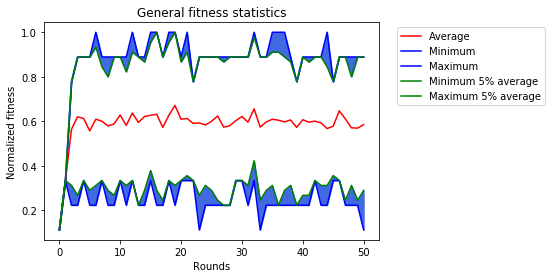

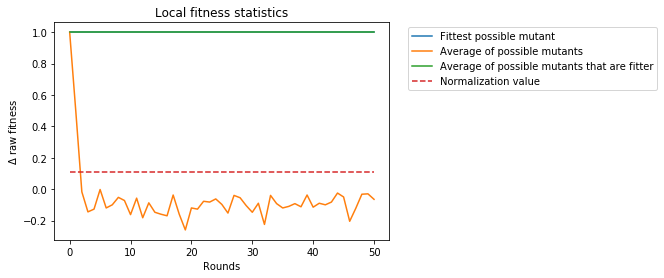

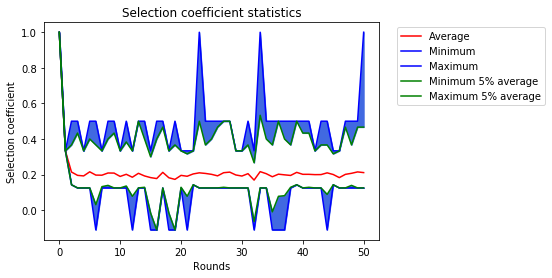

In [28]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.5
rounds = 50
orgNum = 100
clause1 = Clause([1],1)
clause2 = Clause([2],1)
clause3 = Clause([3],1)
clause4 = Clause([4],1)
clause5 = Clause([5],1)
clause6 = Clause([6],1)
clause7 = Clause([7],1)
clause8 = Clause([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

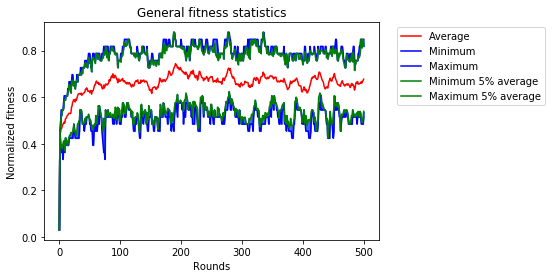

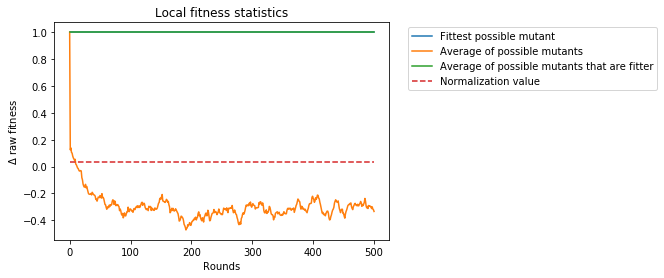

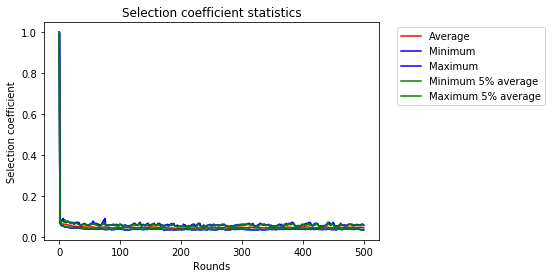

In [31]:
initial = [0] * 32
probability = 0.01
rounds = 500
orgNum = 100
clause1 = Clause([1],1)
clause2 = Clause([2],1)
clause3 = Clause([3],1)
clause4 = Clause([4],1)
clause5 = Clause([5],1)
clause6 = Clause([6],1)
clause7 = Clause([7],1)
clause8 = Clause([8],1)
clause9 = Clause([9],1)
clause10 = Clause([10],1)
clause11 = Clause([11],1)
clause12 = Clause([12],1)
clause13 = Clause([13],1)
clause14 = Clause([14],1)
clause15 = Clause([15],1)
clause16 = Clause([16],1)
clause17 = Clause([17],1)
clause18 = Clause([18],1)
clause19 = Clause([19],1)
clause20 = Clause([20],1)
clause21 = Clause([21],1)
clause22 = Clause([22],1)
clause23 = Clause([23],1)
clause24 = Clause([24],1)
clause25 = Clause([25],1)
clause26 = Clause([26],1)
clause27 = Clause([27],1)
clause28 = Clause([28],1)
clause29 = Clause([29],1)
clause30 = Clause([30],1)
clause31 = Clause([31],1)
clause32 = Clause([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

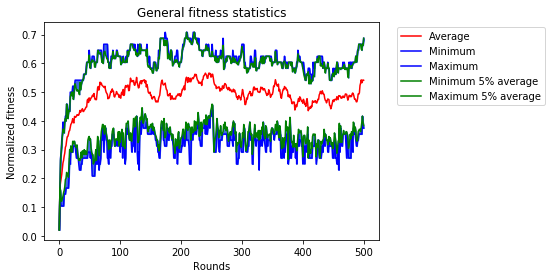

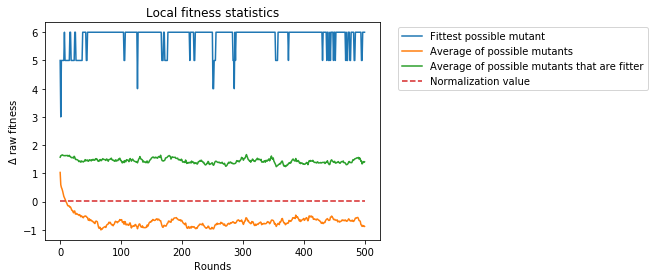

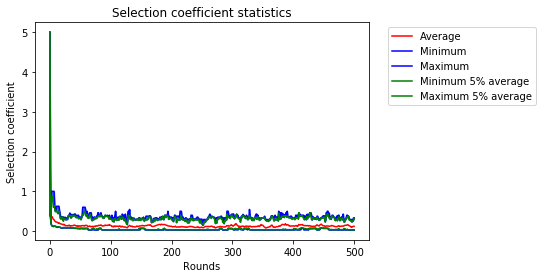

In [32]:
initial = [0] * 32
probability = 0.01
rounds = 500
orgNum = 100
clause1 = Clause([1,5,7],1)
clause2 = Clause([2,1,3],2)
clause3 = Clause([-3,5,7],1)
clause4 = Clause([4,2],1)
clause5 = Clause([-5,3],2)
clause6 = Clause([-6,18],1)
clause7 = Clause([7,23],1)
clause8 = Clause([8,-19],3)
clause9 = Clause([9,-1],1)
clause10 = Clause([10,-6],1)
clause11 = Clause([11,-12,-22],2)
clause12 = Clause([12,11],1)
clause13 = Clause([13,14],1)
clause14 = Clause([14,-1],5)
clause15 = Clause([15,-29],1)
clause16 = Clause([16,32],1)
clause17 = Clause([17,-31],1)
clause18 = Clause([18,5],1)
clause19 = Clause([19,4],1)
clause20 = Clause([20,17],3)
clause21 = Clause([21,-7],1)
clause22 = Clause([22,-2],1)
clause23 = Clause([-23,4],1)
clause24 = Clause([24,-7],1)
clause25 = Clause([25,-6],1)
clause26 = Clause([26,-2],1)
clause27 = Clause([27],2)
clause28 = Clause([28],1)
clause29 = Clause([29],3)
clause30 = Clause([30],1)
clause31 = Clause([31],2)
clause32 = Clause([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

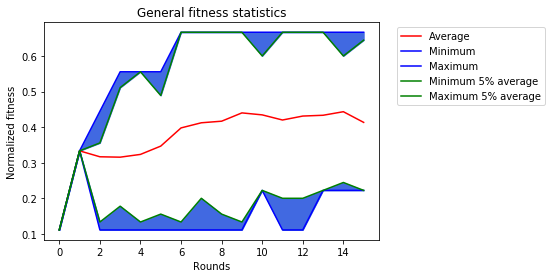

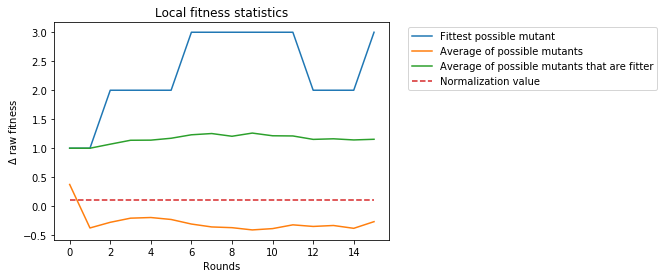

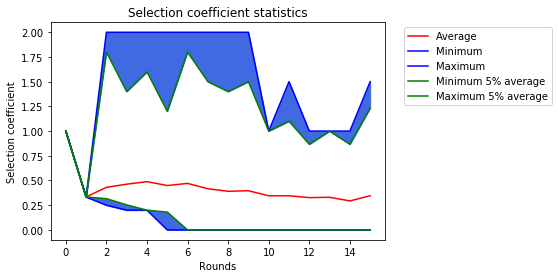

In [33]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.05
rounds = 15
orgNum = 100
clause1 = Clause([1,2,3],1)
clause2 = Clause([5,-4,7],1)
clause3 = Clause([6,7],1)
clause4 = Clause([1,-2],1)
clause5 = Clause([5,8],1)
clause6 = Clause([6,-8],1)
clause7 = Clause([7,-3],1)
clause8 = Clause([8,3],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

In [ ]:
#Observations:
#    Under this model, they tend to converge to an optimum quite fast
    
#What to do:
#    How to select the children / try various methods
#    For local statistics, how to plot the individuals
#    Use joyplots

[3]
